# Predict peak load hours

Given three historical load data from 2005 to 2007, in this exercise, I will demonstrate how I approach predicting the peak load hours in 2008

## Set up project path

In [1]:
import sys
from pathlib import Path
notebook_path = sys.path[0]
sys.path.append(str(Path(notebook_path).parent))
print(sys.path)

['/home/ronin/Cloud_Drive/AI_works/Projects/Amperon/notebook', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ronin/Cloud_Drive/AI_works/Projects/Amperon/venv/lib/python3.8/site-packages', '/home/ronin/Cloud_Drive/AI_works/Projects/Amperon']


In [2]:
import pandas

from load_prediction import DATA_DIR

# Define constants
N_STATION = 28
N_EXP = 1000
N_WORKERS = 10
PREDICTION_OUTPUT_DIR = DATA_DIR / "predictions"
LOAD_PREDICTION_FILE_NAME = "load_predict"

# Load data
hist_data = pandas.read_csv(DATA_DIR / "load_hist_data.csv")
weather_data = pandas.read_csv(DATA_DIR / "weather_data.csv")
prediction = pandas.read_csv(DATA_DIR / "probability_estimates.csv")

Add temperature information to hist_data to prepare features...

In [3]:
for station_id in range(1, N_STATION + 1):
    temperature = weather_data.query(f"`Station ID` == {station_id}")["Temperature"].values
    hist_data.insert(len(hist_data.columns), f"Station_{station_id}_T", temperature, True)

## Data visualization
### Average trend
First, I would like to observe the seasonal trend of average daily load during the three years

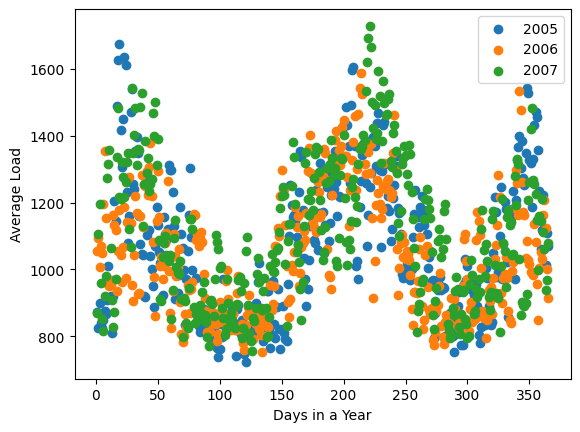

In [4]:
from load_prediction.utils.data_manipulators import Date
from matplotlib import pyplot as plt

dates = []
for d in hist_data["Date"].values:
    if d not in dates:
        dates.append(d)
dates = list(map(Date, [d for d in dates]))
avg_loads = []
for d in dates:
    avg_loads.append(hist_data.query(f"Date == '{d.input_str}'")["Load"].mean())

# Visualize average load vs days in a year from historical data
plt.scatter([d.days_in_year for d in dates if d.year == 2005], [load for d, load in zip(dates, avg_loads) if d.year==2005], label="2005")
plt.scatter([d.days_in_year for d in dates if d.year == 2006], [load for d, load in zip(dates, avg_loads) if d.year==2006], label="2006")
plt.scatter([d.days_in_year for d in dates if d.year == 2007], [load for d, load in zip(dates, avg_loads) if d.year==2007], label="2007")
plt.legend()
plt.xlabel("Days in a Year")
plt.ylabel("Average Load")
plt.show()

Next, I want to observe how the hourly trend varies in holidays and non-holidays.
In the context below, holidays are defined as Federal holidays and weekends.
### Hourly trend in winter
During holidays

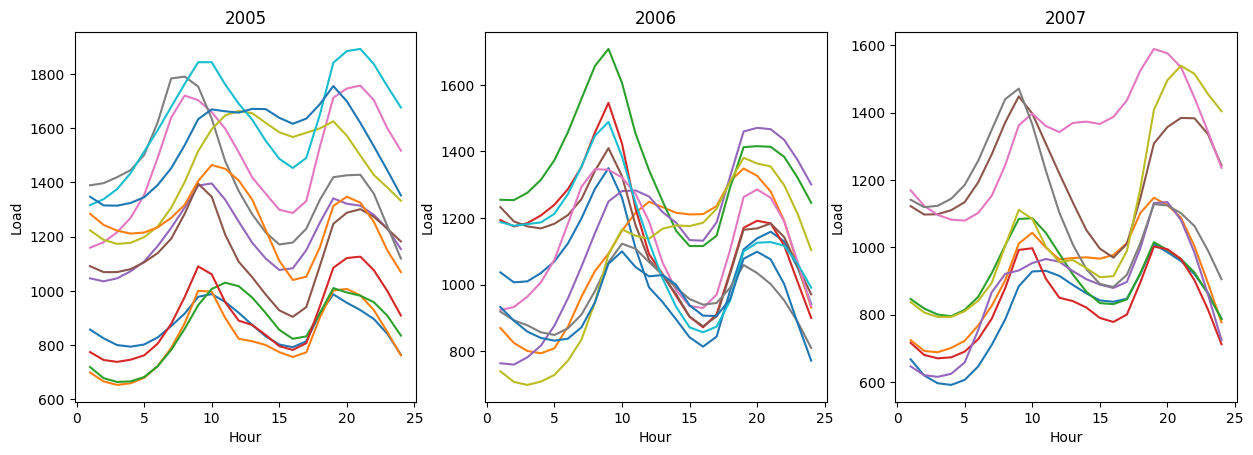

In [5]:
x = [h + 1 for h in range(24)]
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 1 and date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

During non-holidays

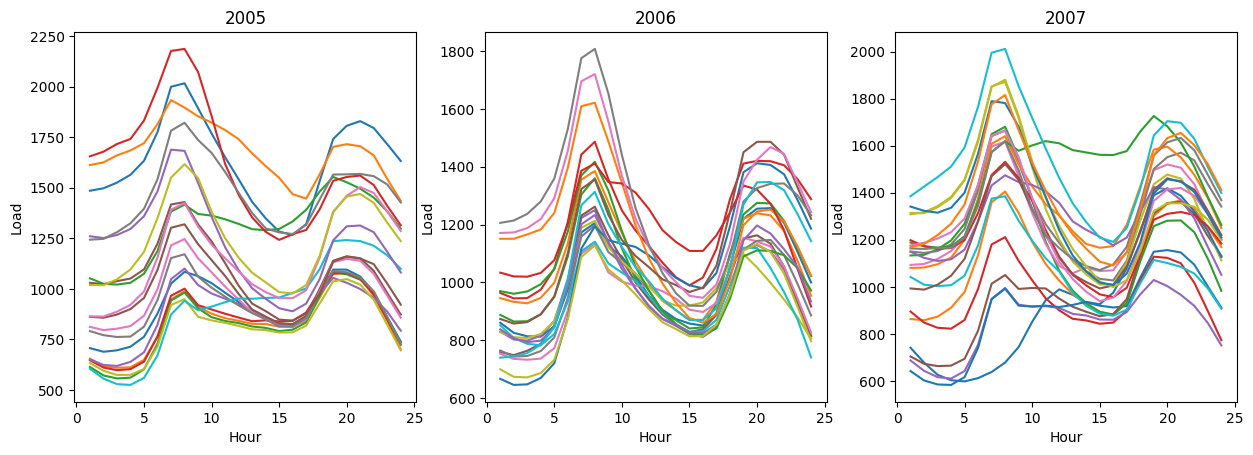

In [6]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 1 and not date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

### Hourly trend in spring
During holidays

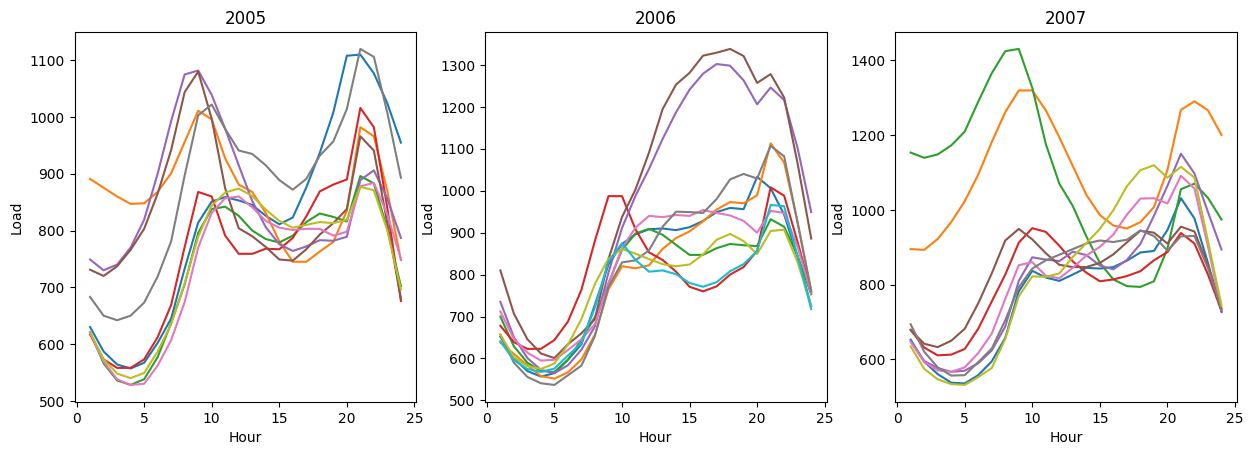

In [7]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 4 and date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

During non-holidays

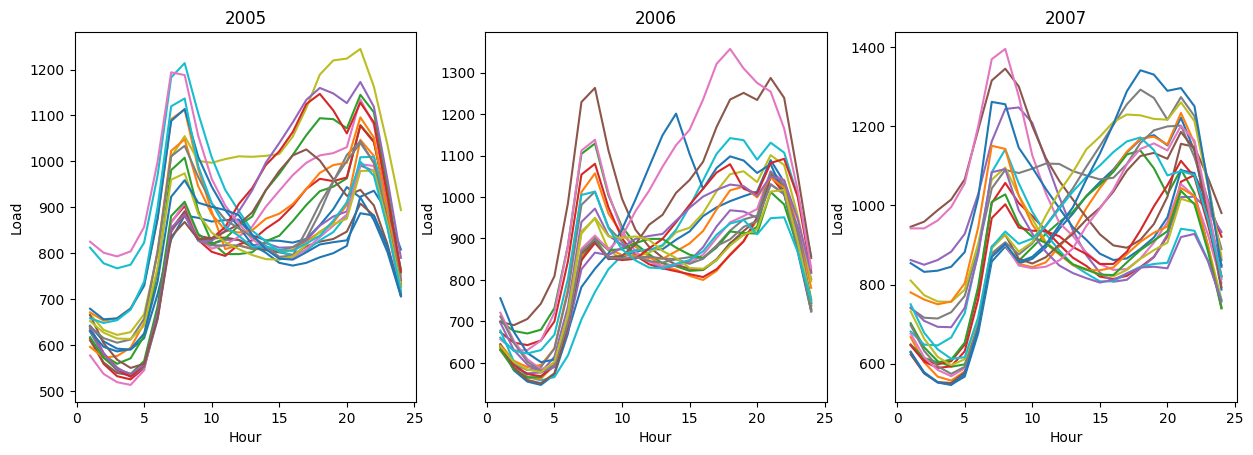

In [8]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 4 and not date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

### Hourly trend in summer
During holidays

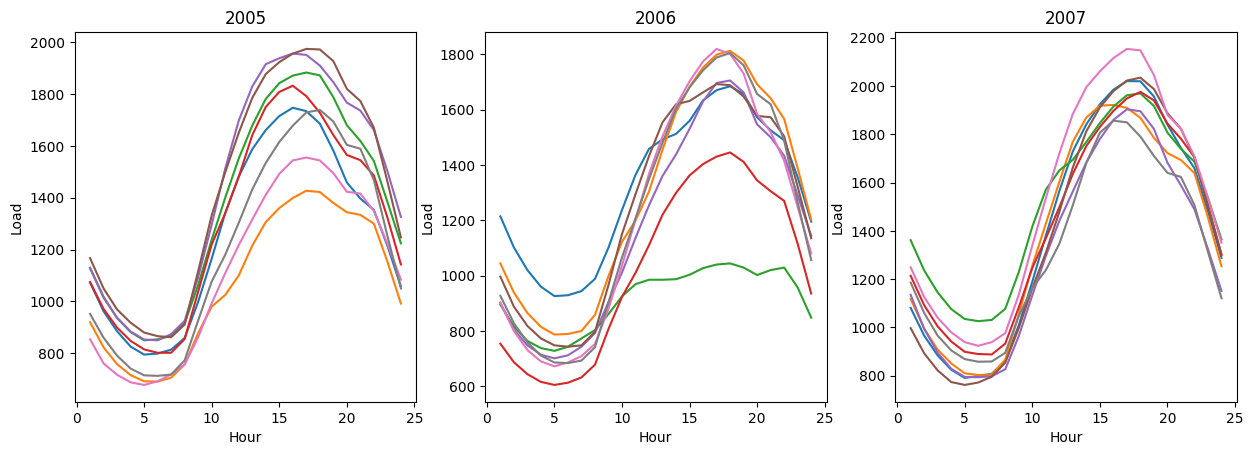

In [9]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 8 and date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

During non-holidays

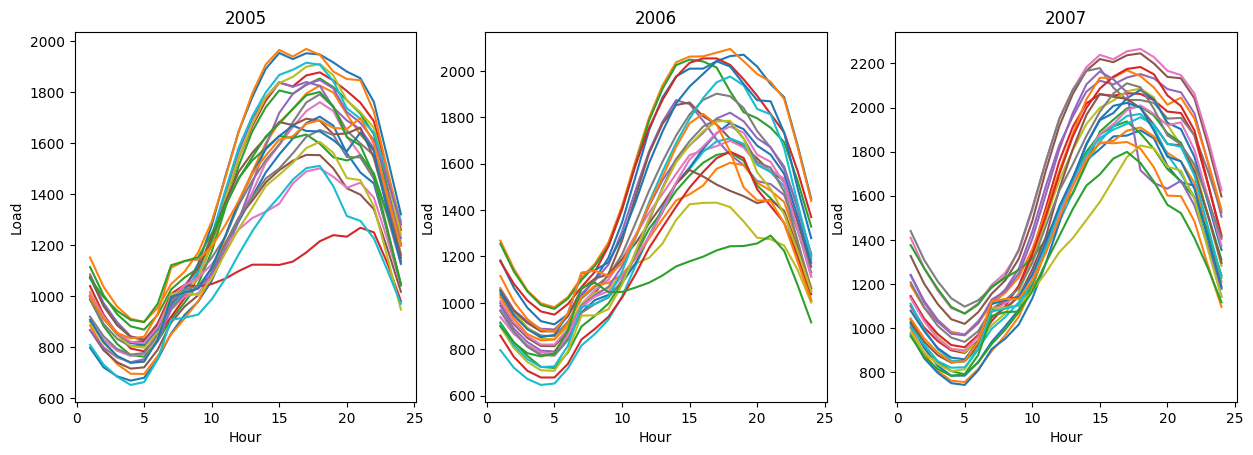

In [10]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 8 and not date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

### Hourly trend in fall
During holidays

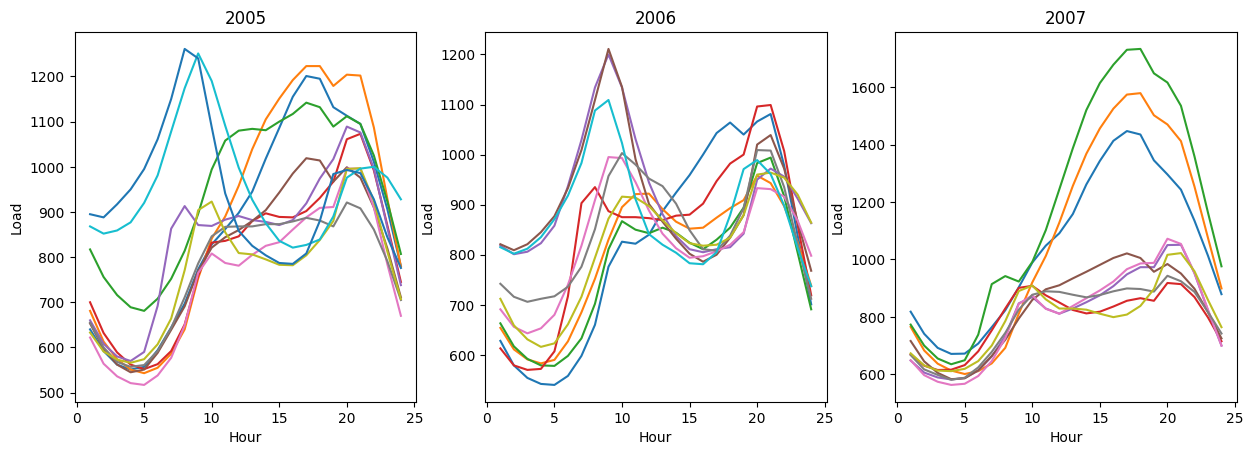

In [11]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 10 and date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

During non-holidays

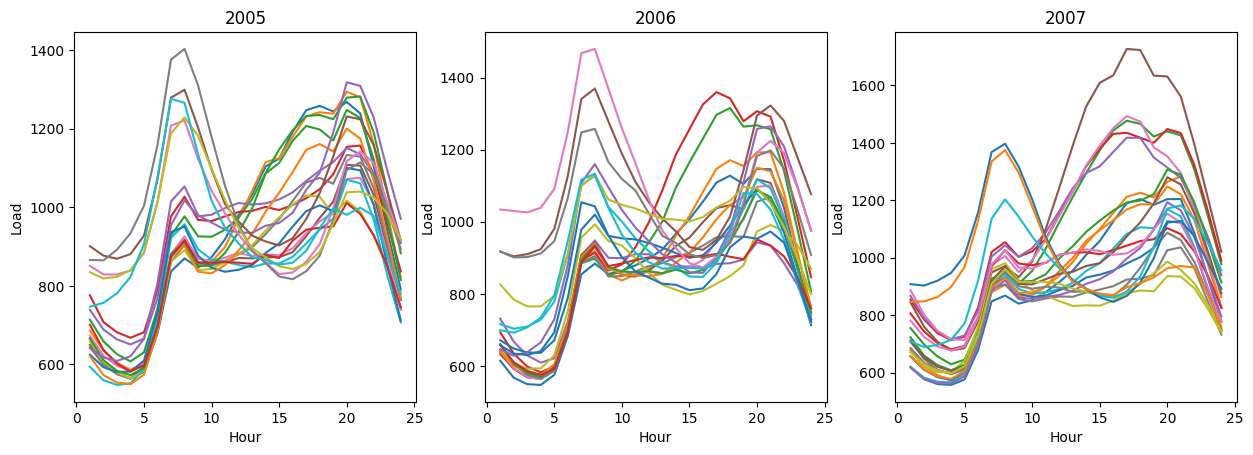

In [12]:
years = [2005, 2006, 2007]
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for date in dates:
    for y_idx, y in enumerate(years):
        if date.month == 10 and not date.is_holiday and date.year == y:
            hours = hist_data.query(f"Date == '{date.input_str}'")["Hour"]
            axs[y_idx].plot(hours, hist_data.query(f"Date == '{date.input_str}'")["Load"].values)
        axs[y_idx].set_xlabel("Hour")
        axs[y_idx].set_ylabel("Load")
        axs[y_idx].set_title(f"{y}")
plt.show()

In the above observation, it appears that during winter, the peak hour tends to fall in AM during non-holidays and equally likely during AM and PM on holidays. In summer, the peak hours seem to consistently fall in PM while the days are hotter. In spring and fall, it is less clear. The peak hours seem to be likely in both AM and PM.

## Training feature preparation
First, it is clear that the hours should be considered in the model

In [13]:
X_all_T = hist_data.drop(["Date", "Load"], axis=1)

The plots above also indicate that the seasonal trend and whether a day is a holiday or not are also important in determining the charge load. Although the variation with years is not obvious, due to the climate change, I will add it as a feature too.

In [14]:
dates = list(map(Date, hist_data["Date"]))
X_all_T.insert(1, "Days_of_Year", [d.days_in_year for d in dates], True)
X_all_T.insert(2, "Year", [d.year for d in dates], True)
X_all_T.insert(3, "Is_Holiday", [d.is_holiday for d in dates], True)
features = ["Days_of_Year", "Year", "Is_Holiday", "Hour"]

One would expect temperature has a direct impact on the charge load. Let's take a look.

In [15]:
# Compute average temperature to be used as a feature as well as a training data
Temp = pandas.DataFrame()
temperatures = X_all_T.drop(features, axis=1)

Text(0, 0.5, 'Load')

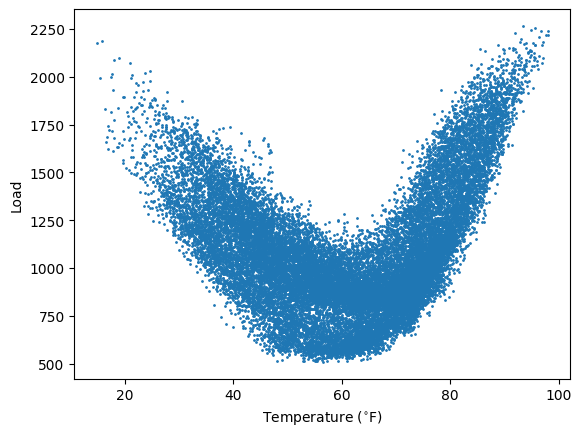

In [16]:
# Visualize average temperature vs load
plt.scatter(temperatures.values.mean(axis=1), list(hist_data["Load"].values), s=1)
plt.xlabel("Temperature ($^{\circ}$F)")
plt.ylabel("Load")

As there is a clear trend between temperature and load, I decide to add temperatures into the features for the load-model training.

In [17]:
Y = hist_data["Load"]
X_avg_T = X_all_T[features]
X_avg_T.insert(len(X_avg_T.columns), "Temperature", temperatures.values.mean(axis=1), True)

## Prediction feature preparation
Next, I prepare required features for predicting hourly load. As temperature information is unknown in 2008, a temperature-prediction model will be trained using the features defined above and the average temperatures data from 2005 and 2007.

In [18]:
# Prepare input for prediction
prediction_dates = list(map(Date, prediction["Date"]))
prediction.insert(1, "Days_of_Year", [d.days_in_year for d in prediction_dates], True)
prediction.insert(2, "Year", [d.year for d in prediction_dates], True)
prediction.insert(3, "Is_Holiday", [d.is_holiday for d in prediction_dates], True)

## Prediction

Here we start training the models, I choose the out of the box `RandomForestRegressor` from `scikit-learn` to predict the hourly loads. As the correlation between each feature and the loads is not linear. There are two models I will be training in the following process:
* mdl_rf_load: this model takes X_avg_T as features and predicts hourly load
* mdl_rf_T: this model takes "Days_of_Year", "Year", and "Hour" as features, and predict temperatures at a given day and hour

We will use predictions from mdl_rf_T with prediction features prepared above to predicts loads

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Build prediction process
def process(n_random):
    # randomly split train and test data by 80% and 20%
    X_train, X_test, Y_train, Y_test = train_test_split(X_avg_T, Y, test_size=0.2, random_state=n_random)
    mdl_rf_load = RandomForestRegressor()
    mdl_rf_load.fit(X_train, Y_train)

    X_T = X_train[["Days_of_Year", "Year", "Hour"]]
    mdl_rf_T = RandomForestRegressor()
    mdl_rf_T.fit(X_T, X_train["Temperature"])

    X_pred = prediction.drop(["Date", "Daily Peak Probability"], axis=1)
    X_pred.insert(len(X_pred.columns), "Temperature", mdl_rf_T.predict(X_pred[["Days_of_Year", "Year", "Hour"]]), True)

    # write out each prediction to a file
    answers = X_pred.copy()
    answers.insert(0, "Date", prediction["Date"], True)
    answers.insert(len(answers.columns), "Load", mdl_rf_load.predict(X_pred), True)
    answers = answers.drop(["Days_of_Year"], axis=1)
    answers.to_csv(PREDICTION_OUTPUT_DIR / f"{LOAD_PREDICTION_FILE_NAME}_{n_random}.csv")

Here we run 1000 predictions in parallel

In [20]:
# 1000 Predictions in parallel
from load_prediction.utils.multi_processing import pmap
n_tries = [n for n in range(N_EXP)]
pmap(process, n_tries, num_workers=8)
print("Prediction complete")

Prediction complete


## Preparing output
Once the prediction is complete, the final step is to output my answer. First, I set up the correct paths for output.

In [21]:
from load_prediction import DATA_DIR

PREDICTIONS_DIR = DATA_DIR / "predictions"
PROB_INPUT = DATA_DIR / "probability_estimates.csv"
PROB_OUTPUT = DATA_DIR / "output/probability_estimates.csv"

I collect results from 1000 predictions and search for the peak hour in each day. For the hour that has the peak load in one prediction, it gets one vote.

In [22]:
import numpy as np
from load_prediction.scripts.prediction import N_EXP
from load_prediction.utils.data_manipulators import PredictionDF

# Use the prabability_estimates.csv to output my answers
vote_df = pandas.read_csv(PROB_INPUT)
# Add the Vote column and set it to zeros
vote_df["Vote"] = np.zeros(len(vote_df), dtype=int)

# Get all dates written in the file
all_dates = set(vote_df["Date"].values)
# Iterate over 1000 predictions
for file in PREDICTIONS_DIR.iterdir():
    predict_df = PredictionDF(file)
    date_to_peak = {date: predict_df.peak_hour_on_date(date) for date in all_dates}
    for date, hour in date_to_peak.items():
        row_idx = vote_df.query(f"Date == '{date}' & Hour == {hour}")["Vote"].index
        vote_df.loc[row_idx, "Vote"] += 1
vote_df.to_csv(DATA_DIR / "output/vote_out.csv")
print("Vote data is ready.")

Vote data is ready.


The probability is then calculated as

$$ {\rm number\ of\ votes} \over {\rm number\ of\ predictions} $$

In [23]:
vote_df["Daily Peak Probability"] = vote_df["Vote"] / N_EXP
vote_df = vote_df.drop(["Vote"], axis=1)
vote_df.to_csv(PROB_OUTPUT)
print("Prediction is complete.")

Prediction is complete.
